# Simple Mercari Price EDA Toturial

![](https://cdn-images-1.medium.com/max/1600/1*jX6Gwn1rt4da7e-yUj84IQ.png)

#### 日本最大電商 Mercari 真實數據，從文字分析，推估建議售價給客戶，您將會了解真實Raw data 樣貌，以及循序漸進的處理方式。
#### 這次Project則是手把手，帶學員走過一次。

In [1]:
import numpy as np
import pandas as pd

import string
import re

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight') 

import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')

## 讀取檔案

In [2]:
PATH = 'data/'
test = pd.read_table(PATH + 'test.tsv',  engine='c')
train = pd.read_table(PATH + 'train.tsv',  engine='c')

In [3]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity



#### 屬性

1. **name**, **brand_name**, **category_name**, **item_description** 四個文字特徵欄位
2. brand_name 歸類成Categorical (nominal = non-ordinal)
3. item_condition_id 也是 Categorical ( nominal range = [1,2,3,4,5])
4. shipping 可以出貨櫃與否 

善用 `value_counts`

## 檢視檔案大小

In [4]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Columns: 8 entries, train_id to item_description
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [5]:
test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Columns: 7 entries, test_id to item_description
dtypes: int64(3), object(4)
memory usage: 37.0+ MB


- Note: 檔案不大，不進行資料型態轉換

## 缺失數據檢視
`isnull`

In [6]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [7]:
test.isnull().sum()

test_id                   0
name                      0
item_condition_id         0
category_name          3058
brand_name           295525
shipping                  0
item_description          0
dtype: int64

## 缺失值，視覺化

請安裝 `missingno` **才能**執行以下的Cell

[Official Doc](https://github.com/ResidentMario/missingno)

這裡使用 missingno 可以看出欄位**位置**的缺失，白色部分，用於檢視，train/test 缺失**分佈位置**。



In [ ]:
# !pip install missingno

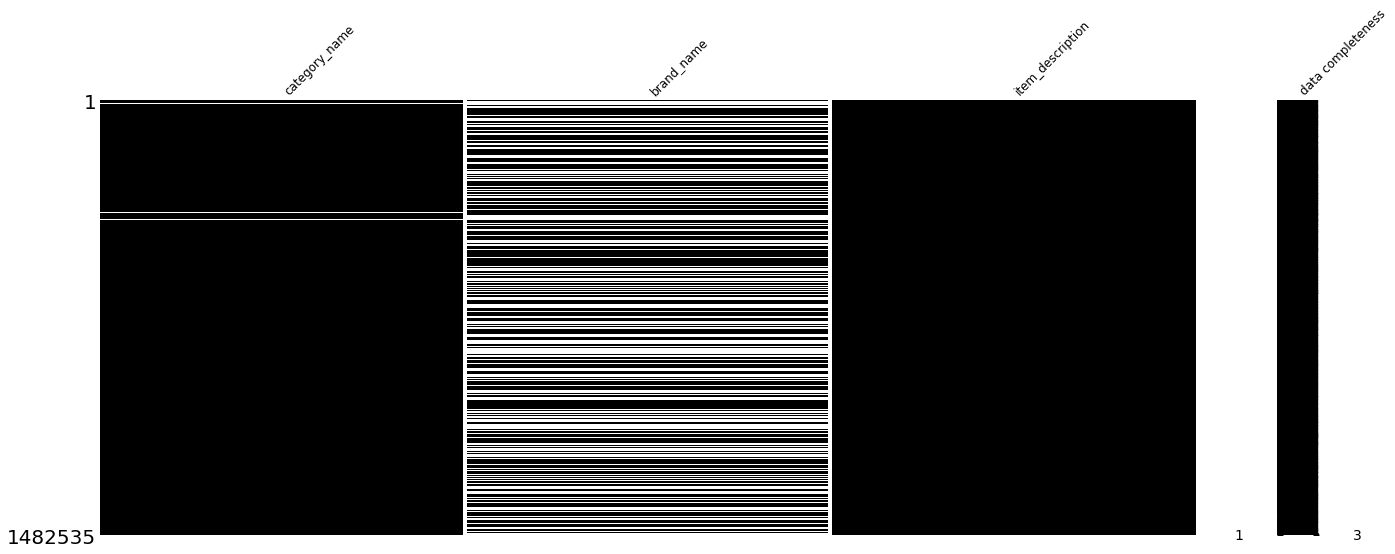

In [8]:
import missingno as msno

def missingno_matrix(df, figsize=(20,8)):
    ''' Missing Value visualization by matrix plot

        Parameters:
        -----------
        df: DataFrame

        Return: matrix plot
        -----------
    '''

    missingValueColumns = df.columns[df.isnull().any()].tolist()
    msno.matrix(df[missingValueColumns],width_ratios=(10,1),\
            figsize=figsize,color=(0, 0, 0),fontsize=12, sparkline=True, labels=True)
    plt.show()
    
missingno_matrix(train)

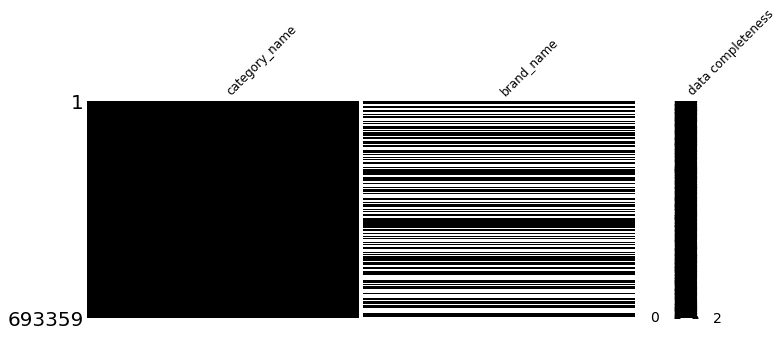

In [9]:
missingno_matrix(test,figsize=(10,4))

#### important Note:
1. 品牌brand_name 存在不少遺失數據
2. category_name 有六千筆遺失數據
3. train跟test缺失數據，可以感覺出 __大概__ 接近__2:1__


# 1. Uni-Variable Analysis

## 1-1. Target Value Analysis (Price)
1. 先對價錢作圖看它分布模式，經驗上，這種數據分佈都會是，常態分佈樣，不然就是long tail
    - `sns.distplot()`


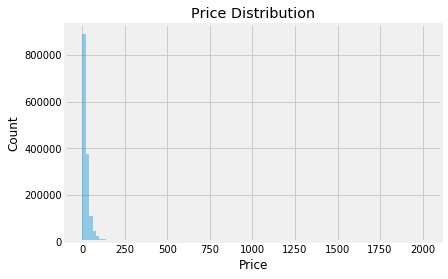

In [10]:
sns.distplot(train['price'], bins=100, kde=False)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

- Q: 很類似一個spike，原因？
- A: 有少數的價錢分佈在250 ~ 2000，這些可以被視為，outlier(離群值，異常值)
### 先排除這些離群數值，使用boolean mask，再重繪圖一次
`train[train['price']<=500]['price']`

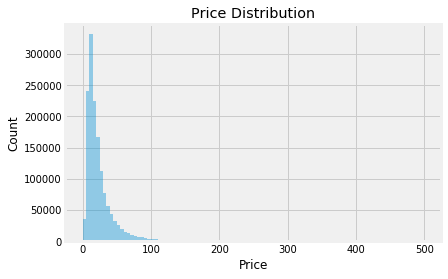

In [11]:
sns.distplot(train[train['price']<=500]['price'], bins=100, kde=False)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

### Important Note:
- 明顯是一個skew分佈
- **Trick** 
    1. 取「對數log」讓他「近似」常態分佈，非線性轉換。
    2. 可以讓outlier 距離拉近，（如果是 standscaler MinMax，outlier 依舊保持一定距離）
    
`np.log1p(train['price'])`
    - log1p = log(目標+1)
    
    - 對應轉換為 
`np.expm1` = exp(目標)-1

### 來看看轉換後是否會「逼近」常態分佈

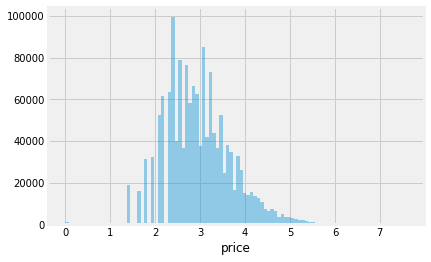

In [12]:
# bins 使用100
sns.distplot(np.log1p(train['price']), bins=100, kde=False)
plt.show()

- Bins如果改小(上圖)
    - 近似的常態分佈出現，也就是outlier被拉近距離！
    
## Hint: 
   - Bins 數加大！


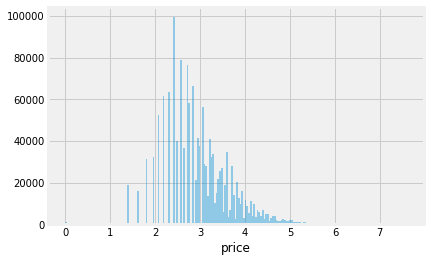

In [13]:
# bins 使用 200
sns.distplot(np.log1p(train['price']), bins=200, kde=False)
plt.show()

### Important Note:


- Bins如果改大，會更**看**得出數據**集中**程度
    - 很明顯，數據集中在3~4 ( log doamin price )
    - 就是中高價位物品為數不少在 3 ~ 4 ( log domain price )


### Exercise:
   繪出`StandardScaler, MinMaxScaler`轉換後的分佈。

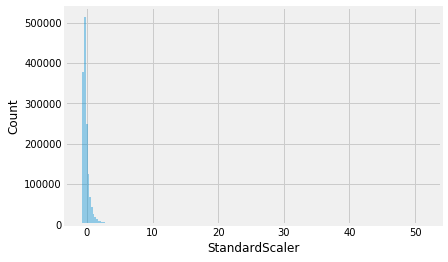

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
s_price = scaler.fit_transform(train['price'].values.reshape(-1, 1))
sns.distplot(s_price, bins=200, kde=False)
plt.xlabel('StandardScaler')
plt.ylabel('Count')
plt.show()
del s_price

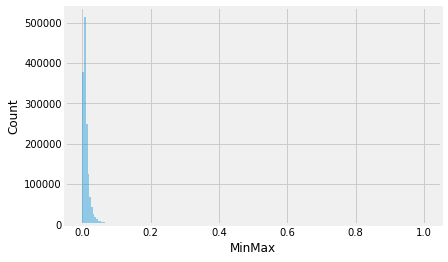

In [15]:
minmax = MinMaxScaler()
mm_price = minmax.fit_transform(train['price'].values.reshape(-1, 1))
sns.distplot(mm_price, bins=200, kde=False)
plt.xlabel('MinMax')
plt.ylabel('Count')
plt.show()
del mm_price

- 因為這是線性轉換，所以無法把outlier拉近

### 總共幾種價錢?
`nunique` # Numbers of Unique

In [16]:
train.price.nunique()

828

- 才828個價錢！！！！

### 最後來看看統計數據
`describe()`

In [17]:
train.price.describe() # train.price等同 train['price']

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64


### 最小值出現「**零**」元，

### 看看零元是什麼東西

In [18]:
train[train['price']==0].head(20)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1325,1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,NaN,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,NaN,0.0,0,"Very simple but cute, a little form fitting as..."
3576,3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,0.0,1,1 left!
3761,3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,NaN,0.0,1,5 pair gap jean excellent used condition 3 chi...
5237,5237,Nursing Bra,3,Women/Underwear/Bras,Motherhood Maternity,0.0,0,Used a few times but was not able to nurse
6175,6175,"Multi Listing Bundled Package, Thanks",2,Electronics/Media/DVD,NaN,0.0,1,1)Large Collection of Full Length Strawberry S...
7116,7116,Nike Dri-Fit High Power Speed Tights,1,"Women/Athletic Apparel/Pants, Tights, Leggings",Nike,0.0,1,"Bought at Nike store in New York, Brand New, N..."
7622,7622,Hands free earpiece,1,Electronics/Cell Phones & Accessories/Headsets,NaN,0.0,0,Wireless Bluetooth hands free used with Samsun...
10812,10812,Vampire candy bowl,1,Home/Seasonal Décor/Halloween,NaN,0.0,0,New good condition for halloween


###  Zero Price 有幾筆，所佔train比重多少

In [19]:
print('總共幾筆零元售價: {}， 所佔比例為 {}%'.format(train[train['price']==0].shape[0], train[train['price']==0].shape[0]/train.shape[0]*100))

總共幾筆零元售價: 874， 所佔比例為 0.05895307699312327%


- 人類直觀來說，售價零元是不合理的數值
- 親自去玩Mercari App，上面不容許售價為零

### 所以，Zero Price 目前歸類為人為錯誤，無法修復，所佔比重很低，所以考慮刪除( 請看CV是否改善)

# 檢視數據分佈
- 傳統上，會檢視訓練/測試數據的變異數，缺失值百分比，類別特徵裡面項目比例...etc.

### Q: 文字數據怎麼檢視？
### A: 同樣做法，簡單地查看train/ test 比例

### 1. 首先，檔案大小比例

In [20]:
train.shape[0]/test.shape[0]

2.1381924803745247

#### Note:
1. 樣本比例約**2.14**
2. 還記得缺失值比例也是約為 2 : 1 嗎？ 這數據起頭已經是好的！

### 2. 檢視 brand_name 裡面品牌數 是否都是漂亮的2 : 1

In [21]:
# Train
df1 = (train.set_index('brand_name').groupby(level=0)['item_condition_id'].agg({'count'})).reset_index()
df1.sort_values(by=['count'],inplace=True, ascending=False)
df1.head(10)


,brand_name,count
3221,PINK,54088
3057,Nike,54043
4504,Victoria's Secret,48036
2604,LuLaRoe,31024
267,Apple,17322
1510,FOREVER 21,15186
3067,Nintendo,15007
2626,Lululemon,14558
2841,Michael Kors,13928
213,American Eagle,13254


In [22]:
# test

df2 = (test.set_index('brand_name').groupby(level=0)['item_condition_id'].agg({'count'})).reset_index()
df2.sort_values(by=['count'],inplace=True, ascending=False)
df2.head(10)

,brand_name,count
2471,Nike,25234
2604,PINK,25004
3653,Victoria's Secret,22472
2110,LuLaRoe,14574
225,Apple,8113
2483,Nintendo,7149
1217,FOREVER 21,7141
2123,Lululemon,6833
2295,Michael Kors,6407
183,American Eagle,6164


#### Note:
前十多的品牌也差不多是2:1，train/test數據可以說分佈很類似

### 看看 item_description裡面 No description yet （形同沒描述）的比例

In [23]:
train[train['item_description']=='No description yet'].shape[0]/test[test['item_description']=='No description yet'].shape[0]   

2.142404487961977

### Awesome..... 也是漂亮的 2 : 1   

### 數據分佈類似有什麼好處？
- 如果檔案不會太小，Local CV 會靠近 Public LB, that is.......

# 你可以相信Public LB